# 6章　ゲート付きRNN

## 6.1 RNNの問題点

- BPTTにおいて、勾配消失、勾配爆発が起こりやすい。

### 6.1.3 勾配消失、勾配爆発の原因

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
N = 2 # ミニバッチサイズ
H = 3 # 隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
# MutMulノードの数だけ、dhを更新
for t in range(T):
    dh = np.dot(dh, Wh.T)
    # dhの大きさとして、ミニバッチにおける平均のN2ノルムを求めている.

    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)

Text(0.5, 1.0, 'explading gradients')

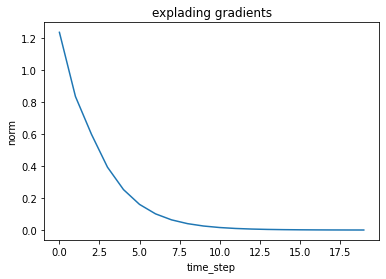

In [16]:
plt.plot(norm_list)
plt.xlabel('time_step')
plt.ylabel('norm')
plt.title('explading gradients')

In [14]:
N = 2 # ミニバッチサイズ
H = 3 # 隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H))
np.random.seed(3)
#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
# MutMulノードの数だけ、dhを更新
for t in range(T):
    dh = np.dot(dh, Wh.T)
    # dhの大きさとして、ミニバッチにおける平均のN2ノルムを求めている.

    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)

Text(0.5, 1.0, 'vanishing gradients')

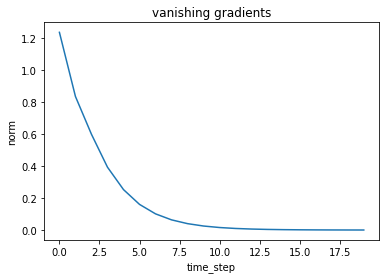

In [17]:
plt.plot(norm_list)
plt.xlabel('time_step')
plt.ylabel('norm')
plt.title('vanishing gradients')

行列の場合は、複数ある行列の特異値の中で、その最大値が１より大きいかどうかで、勾配の大きさの変化を予測することができる。

## 6.1.4 勾配爆発への対策 

### 勾配クリッピング 

In [21]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    """
    grads: 勾配のリスト
    max_norm: 閾値
    """
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad += rate

In [22]:
clip_grads(grads, max_norm)

## 6.2 勾配消失とLSTM
- outputゲート O
  - 隠れ状態のhtの出力を司る。
- forgetゲート f
  - 何を忘れるか？
- 新しい記憶セル g
  - 新しく覚えるべき情報を記憶セルに追加する
  - 活性化にtanhを使用
- inputゲート i
  - gの各要素が新たに追加する情報としてどれだけ価値があるかを判断
  - 追加する情報の取捨選択を行う
 
  
- LSTMの逆伝播では+ノードとxノード（アダマール積: 要素毎の積）しかないので、逆伝播の際に、毎時刻異なるゲート値によって要素毎の積の計算が行われる。
- そのため、勾配消失を起こさない（もしくは起こしにくい）

## 6.3 LSTMの実装

In [24]:
class LSTM(object):
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(f)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

In [25]:
class TimeLSTM(object):
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = None
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Ws.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_staete(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTMを使った言語モデル

In [27]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

In [28]:
class Rnnlm(object):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

## PTBデータセットの学習

In [30]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 35 # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity', ppl_test)

# パラメータの保存
model.save_params()

Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.00
| epoch 1 |  iter 21 / 1327 | time 5[s] | perplexity 3030.38
| epoch 1 |  iter 41 / 1327 | time 8[s] | perplexity 1265.49
| epoch 1 |  iter 61 / 1327 | time 12[s] | perplexity 974.93
| epoch 1 |  iter 81 / 1327 | time 16[s] | perplexity 788.96
| epoch 1 |  iter 101 / 1327 | time 19[s] | perplexity 639.49
| epoch 1 |  iter 121 / 1327 | time 23[s] | perplexity 655.80
| epoch 1 |  iter 141 / 1327 | time 28[s] | perplexity 606.15
| epoch 1 |  iter 161 / 1327 | time 32[s] | perplexity 578.78
| epoch 1 |  iter 181 / 1327 | time 36[s] | perplexity 578.69
| epoch 1 |  iter 201 / 1327 | time 40[s] | perplexity 502.78
| epoch 1 |  iter 221 / 1327 | time 44[s] | perplexity 489.69
| epoch 1 |  iter 241 / 1327 | time 48[s] | perplexity 447.22
| epoch 1 |  iter 261 / 1327 | time 52[s] | perplexity 459.47
| epoch 1 |  iter 281 / 1327 | time 57[s] | perplexity 450.05
| epoch 1 |  iter 301 / 1327 | time 61[s] | perplexity 384.66
| epoch 

KeyboardInterrupt: 

## 6.5 RNNLMのさらなる改善
- LSTMレイヤの多層化
- Dropoutを使用（深さ方向にのみ適用）
- 重み共有（EmbeddingレイヤとAffineレイヤで重み共有）

In [33]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, word_vec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # ３つの改善
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeAffine(embed_W.T, affine_b) # 重みの共有
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = [self.layers[2], self.layers[4]]
        self.drop_layer = [self.layers[1], self.layers[3], self.layers[5]]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = trian_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

### 改善したBetterRnnlmクラスで学習

In [36]:
import sys
sys.path.append('..')
from common import config

# ハイパーパラメータの設定
batch_size = 20
word_vec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
triner = RnnlmTrainer(model, optimizer)

bast_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplecity:', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        model.reset_state()
        print('-' * 50)

| epoch 2 |  iter 1 / 1327 | time 0[s] | perplexity 237.60
| epoch 2 |  iter 21 / 1327 | time 3[s] | perplexity 149.69
| epoch 2 |  iter 41 / 1327 | time 6[s] | perplexity 141.65
| epoch 2 |  iter 61 / 1327 | time 9[s] | perplexity 133.76
| epoch 2 |  iter 81 / 1327 | time 12[s] | perplexity 116.26
| epoch 2 |  iter 101 / 1327 | time 16[s] | perplexity 110.92
| epoch 2 |  iter 121 / 1327 | time 19[s] | perplexity 123.08
| epoch 2 |  iter 141 / 1327 | time 23[s] | perplexity 137.31
| epoch 2 |  iter 161 / 1327 | time 26[s] | perplexity 148.24
| epoch 2 |  iter 181 / 1327 | time 30[s] | perplexity 153.32


KeyboardInterrupt: 